# Project Production Process
- Carlo Dieltjens - Raf Mesotten - Yannick Pottiez
- April 2024

## Step 0: Import

#### Libraries

In [1]:
import pandas as pd
import numpy as np
import os
import json
import sys
import matplotlib.pyplot as plt 

#### Functions

In [2]:
sys.path.append('../scripts')  # define path containing scripts
from read_files import read_json_files
from segment_calculations import create_segments
from segment_calculations import print_segment_share
from segment_calculations import calculate_and_save_segments_values
from simulate import simulate
from make_a_chart import calculate_maximum
from make_a_chart import plot_histogram
from make_a_chart import plot_multiple_histograms
from make_a_chart import plot_cdf
from make_a_chart import plot_segment_distributions

## Step 1: Download and organize data

#### Define input paths
All input in folder ```data\input```.

In [3]:
input_path = os.path.join('..', 'data', 'input')
output_path = os.path.join('..', 'data', 'output')

# Define paths for BRU en STO
directory_path_BRU = os.path.join(input_path, 'data_production', 'daily_production', 'BRU')
directory_path_STO = os.path.join(input_path, 'data_production', 'daily_production', 'STO')

## Step 2: Initialize Git Repository
https://github.com/craftyraf/project-productie-proces

## Step 3: Create a virtual environment using Anaconda

Only the used packages were installed. README.md describes deployment of the virtual environment.

## Step 4: Reading data in Python
Write code to read all the data from Step 1 into Python.

#### Read 1 .json file 

In [4]:
df = pd.read_json(os.path.join(input_path, 
                               'data_production', 
                               'daily_production', 
                               'BRU', 
                               '20180101.json'), 
                  orient='index')
df

,0
DoW,Monday
hour,1
minute,0
date,01-01-2018 00:00:00.0000
maintenance,No
prod_loss,61
prod_loss_perc,5
production,1183


#### Read all .json files and combine them in 1 dataframe for all locations (including extra column 'location') 

In [5]:
# Read JSON files and create dataframe with location column
BRU_df = read_json_files(directory_path_BRU, 'BRU')
STO_df = read_json_files(directory_path_STO, 'STO')

# Concatenate BRU and STO DataFrames
combined_df = pd.concat([BRU_df, STO_df], ignore_index=True)
combined_df

,DoW,hour,minute,date,maintenance,prod_loss,prod_loss_perc,production,location
0,Monday,1,0,01-01-2018 00:00:00.0000,No,61,5,1183,BRU
1,Tuesday,1,0,01-02-2018 00:00:00.0000,No,106,9,1138,BRU
2,Wednesday,1,0,01-03-2018 00:00:00.0000,No,129,10,1115,BRU
3,Thursday,1,0,01-04-2018 00:00:00.0000,No,278,22,966,BRU
4,Friday,1,0,01-05-2018 00:00:00.0000,No,218,17,1026,BRU
...,...,...,...,...,...,...,...,...,...
3655,Saturday,1,0,12-31-2022 00:00:00.0000,No,51,19,223,STO
3656,Sunday,1,0,01-01-2023 00:00:00.0000,No,53,20,221,STO
3657,Monday,1,0,01-02-2023 00:00:00.0000,No,61,22,213,STO
3658,Tuesday,1,0,01-03-2023 00:00:00.0000,No,70,25,204,STO


#### Filter all records with maintance 

In [6]:
# Unique records with number of 'maintenance' in BRU_df
unique_values_counts = combined_df['maintenance'].value_counts()
print(unique_values_counts)

# Retain only records with 'maintenance = No'
combined_df_no_maintenance = combined_df[combined_df['maintenance'] == 'No']

maintenance
No     3452
Yes     208
Name: count, dtype: int64


#### Control the presence of NaN values in the dataframe

No NaN in combined_df_no_maintenance:

In [7]:
print("Amount of NaN-values per column in combined_df_no_maintenance:")
for column in combined_df_no_maintenance.columns:
    nan_count = combined_df_no_maintenance[column].isna().sum()
    print(f"{column}: {nan_count}")

Amount of NaN-values per column in combined_df_no_maintenance:
DoW: 0
hour: 0
minute: 0
date: 0
maintenance: 0
prod_loss: 0
prod_loss_perc: 0
production: 0
location: 0


#### Check datatypes and convert to the correct format 

In [8]:
combined_df_no_maintenance.dtypes

DoW               object
hour               int64
minute             int64
date              object
maintenance       object
prod_loss         object
prod_loss_perc    object
production        object
location          object
dtype: object

In [9]:
# Create a new dataframe containing cleaned numeric columns
combined_df_cleaned = combined_df_no_maintenance.copy()

# Convert columns to numeric columns 
combined_df_cleaned['prod_loss'] = pd.to_numeric(combined_df_cleaned['prod_loss'], errors='coerce')
combined_df_cleaned['prod_loss_perc'] = pd.to_numeric(combined_df_cleaned['prod_loss_perc'], errors='coerce')
combined_df_cleaned['production'] = pd.to_numeric(combined_df_cleaned['production'], errors='coerce')

print(combined_df_cleaned.dtypes)

DoW               object
hour               int64
minute             int64
date              object
maintenance       object
prod_loss          int64
prod_loss_perc     int64
production         int64
location          object
dtype: object


#### Create a histogram per location

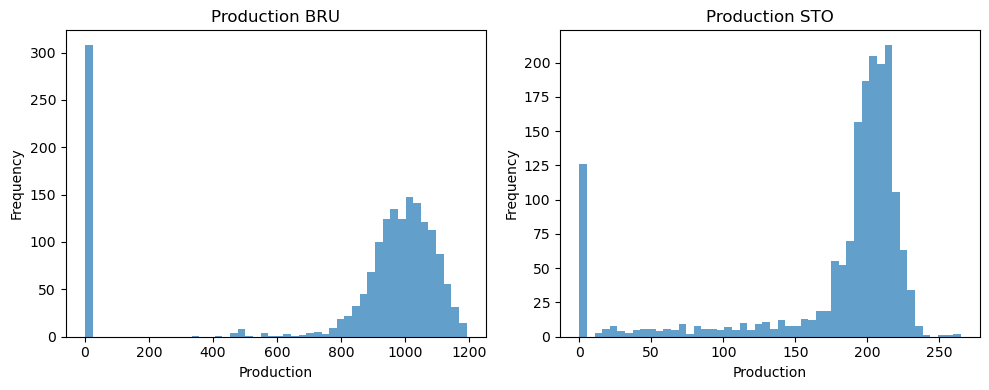

In [10]:
# Obtain the unique locations
unique_locations = combined_df_cleaned['location'].unique()

# Calculate the number of rows and columns needed for the subplots
n_locs = len(unique_locations)
n_cols = 2
n_rows = n_locs // n_cols + (n_locs % n_cols > 0)

# Create a figure and axis for the subplots
fig, axs = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows), squeeze=False)

for i, loc in enumerate(unique_locations):
    # Calculate the current row and column
    row = i // n_cols
    col = i % n_cols
    
    # Filter data for current location
    loc_data = combined_df_cleaned[combined_df_cleaned['location'] == loc]['production']
    
    # Plot histogram for current location
    axs[row, col].hist(loc_data, bins=50, alpha=0.7)
    axs[row, col].set_title(f'Production {loc}')
    axs[row, col].set_xlabel('Production')
    axs[row, col].set_ylabel('Frequency')

# Hide unnecessary subplots if the amount of locations does not fit the grid 
for i in range(n_locs, n_rows * n_cols):
    fig.delaxes(axs.flatten()[i])

# Show the plot
plt.tight_layout()
plt.show()

## Step 5: Determine a suitable distribution for the daily production process
Investigate and determine an appropriate probability distribution that best fits the characteristics of the
production process on a day when there should normally be normal production based on the
facts.

The graphs above clearly shows that a normal distribution will not be sufficient to fit the data. The reason is the large peak at 0, but also the long left tail together with the short right tail. For that reason, we decide to divide our histograms (visually) into 3 parts, and find a suitable fit for each part. Days on which we know there is no production (due to planned maintenance) are not taken into account. Days on which production is unexpectedly 0 will be taken into account.

In both cases we choose:
- a point distribution at 0,
- a uniform distribution for the intermediate part,
- a normal distribution for the 'normal' production.

Locatie: BRU
BRU: % days with [production < 1e-08]: 17.74 %
BRU: % days with [1e-08 <= production < 750]: 2.13 %
BRU: % days with [production >= 750]: 80.13 %


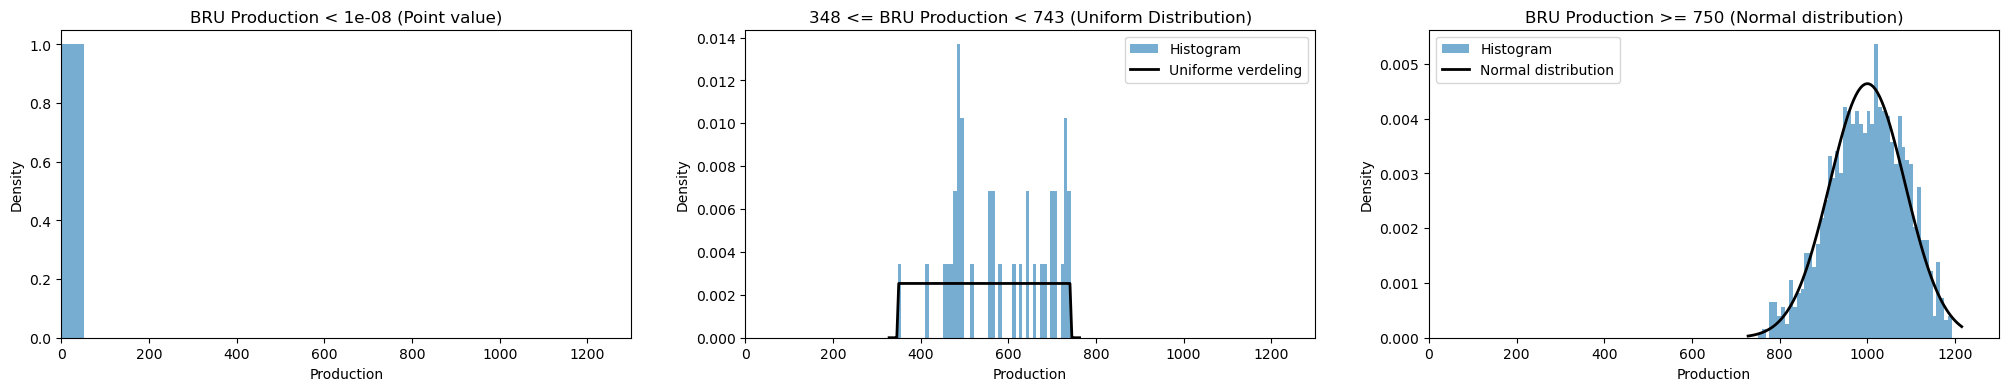

Locatie: STO
STO: % days with [production < 1e-08]: 7.34 %
STO: % days with [1e-08 <= production < 150]: 9.62 %
STO: % days with [production >= 150]: 83.04 %


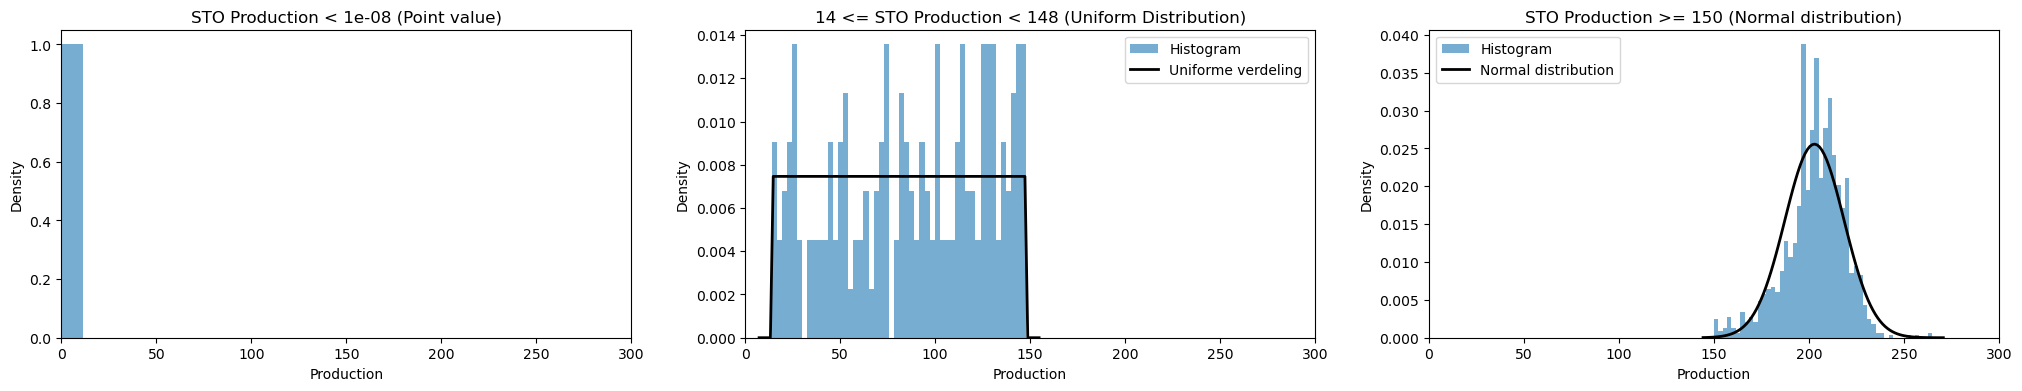

In [11]:
# Input parameters for both locations
unique_locations = combined_df_cleaned['location'].unique()
threshold_1 = 10**(-8)

location_threshold_2 = {
    'BRU': 750,
    'STO': 150
}


# Iterate over unique locations, create segments based on thresholds, and perform calculations
for i,j in enumerate(unique_locations):
    
    # Use the function 'create_segments' to create the segments (borders were determined visually)
    # and calculate the share per segment 
    location = list(location_threshold_2.keys())[i]
    print('Locatie:', location)
    threshold_2 = list(location_threshold_2.values())[i]
    
    share_1, share_2, share_3, \
    segment_1, segment_2, segment_3 = create_segments(location,
                                                      threshold_1,
                                                      threshold_2,
                                                      combined_df_cleaned)
    
    # Print share per segment
    print_segment_share(location, threshold_1, threshold_2, share_1, share_2, share_3)
    
    # Calculate import segment values and save them in a json file
    filename = os.path.join(output_path, f'{location}.json')
    results = calculate_and_save_segments_values(location,
                                                 threshold_1,
                                                 threshold_2,
                                                 share_1,
                                                 segment_2,
                                                 segment_3,
                                                 share_2,
                                                 share_3,
                                                 filename)
    
    # Generate charts for all 3 segments
    maximum = calculate_maximum(combined_df_cleaned, unique_locations[i])
    plot_segment_distributions(segment_1, 
                               segment_2, results[location]['lower_bound_s2'], results[location]['upper_bound_s2'],
                               segment_3, results[location]['param1_s3'], results[location]['param2_s3'],                          
                               location, 
                               threshold_1, 
                               threshold_2, 
                               maximum)

## Step 6: Develop simulation program

Enter the location you want to simulate (BRU or STO):  bru
Enter the number of days for simulation:  7


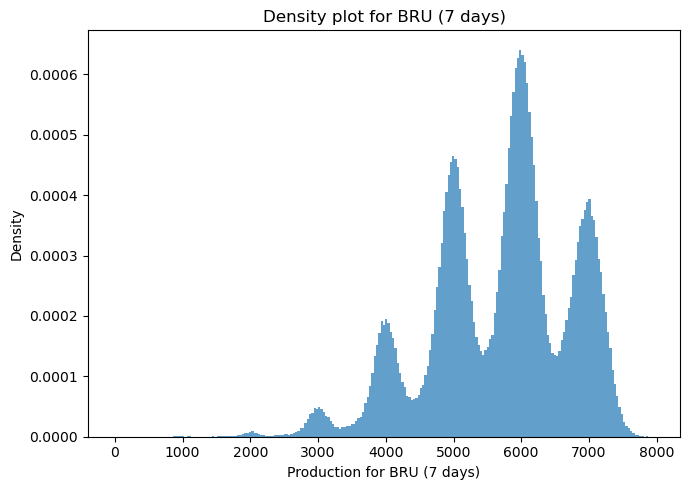

In [12]:
# Ask the user to input the location (with errorhandling)
while True:
    location = input("Enter the location you want to simulate (BRU or STO): " ).upper()
    if location not in ['BRU', 'STO']:
        print("The location entered is not valid. Enter a valid location (BRU or STO).")
        continue
    else:
        break

# Ask the user to enter the number of days
n_days_values = [(input("Enter the number of days for simulation: "))] # type 'list' because simulate function works with list


# Open the JSON file and load its contents
filename = os.path.join(output_path, f'{location}.json')

with open(filename, 'r') as json_file:
    data = json.load(json_file)

# Extract specific values from the loaded JSON data
share_1, share_2, lower_bound_s2, upper_bound_s2, param1_s3, param2_s3 = \
    (data[location][key] for key in ['share_1', 'share_2',
                                     'lower_bound_s2', 'upper_bound_s2',
                                     'param1_s3', 'param2_s3'])


# Simulate data for each n_days value and plot histograms and CDFs
fig, axs = plt.subplots(len(n_days_values), figsize=(7, 5*len(n_days_values)))

for i, n_days in enumerate(n_days_values):
    # Simulate data
    simulated_data = simulate(share_1, share_2, lower_bound_s2, upper_bound_s2, param1_s3, param2_s3, int(n_days))
    
    # Plot histogram
    plot_histogram(simulated_data, int(n_days), location)

## Step 7 Use your simulation + comparison with the Central Limit Theorem
Use your simulation program to simulate the production probabilities over a period of n days. Make
also a graph of the empirical CDF.

Enter the location you want to simulate (BRU or STO):  bru


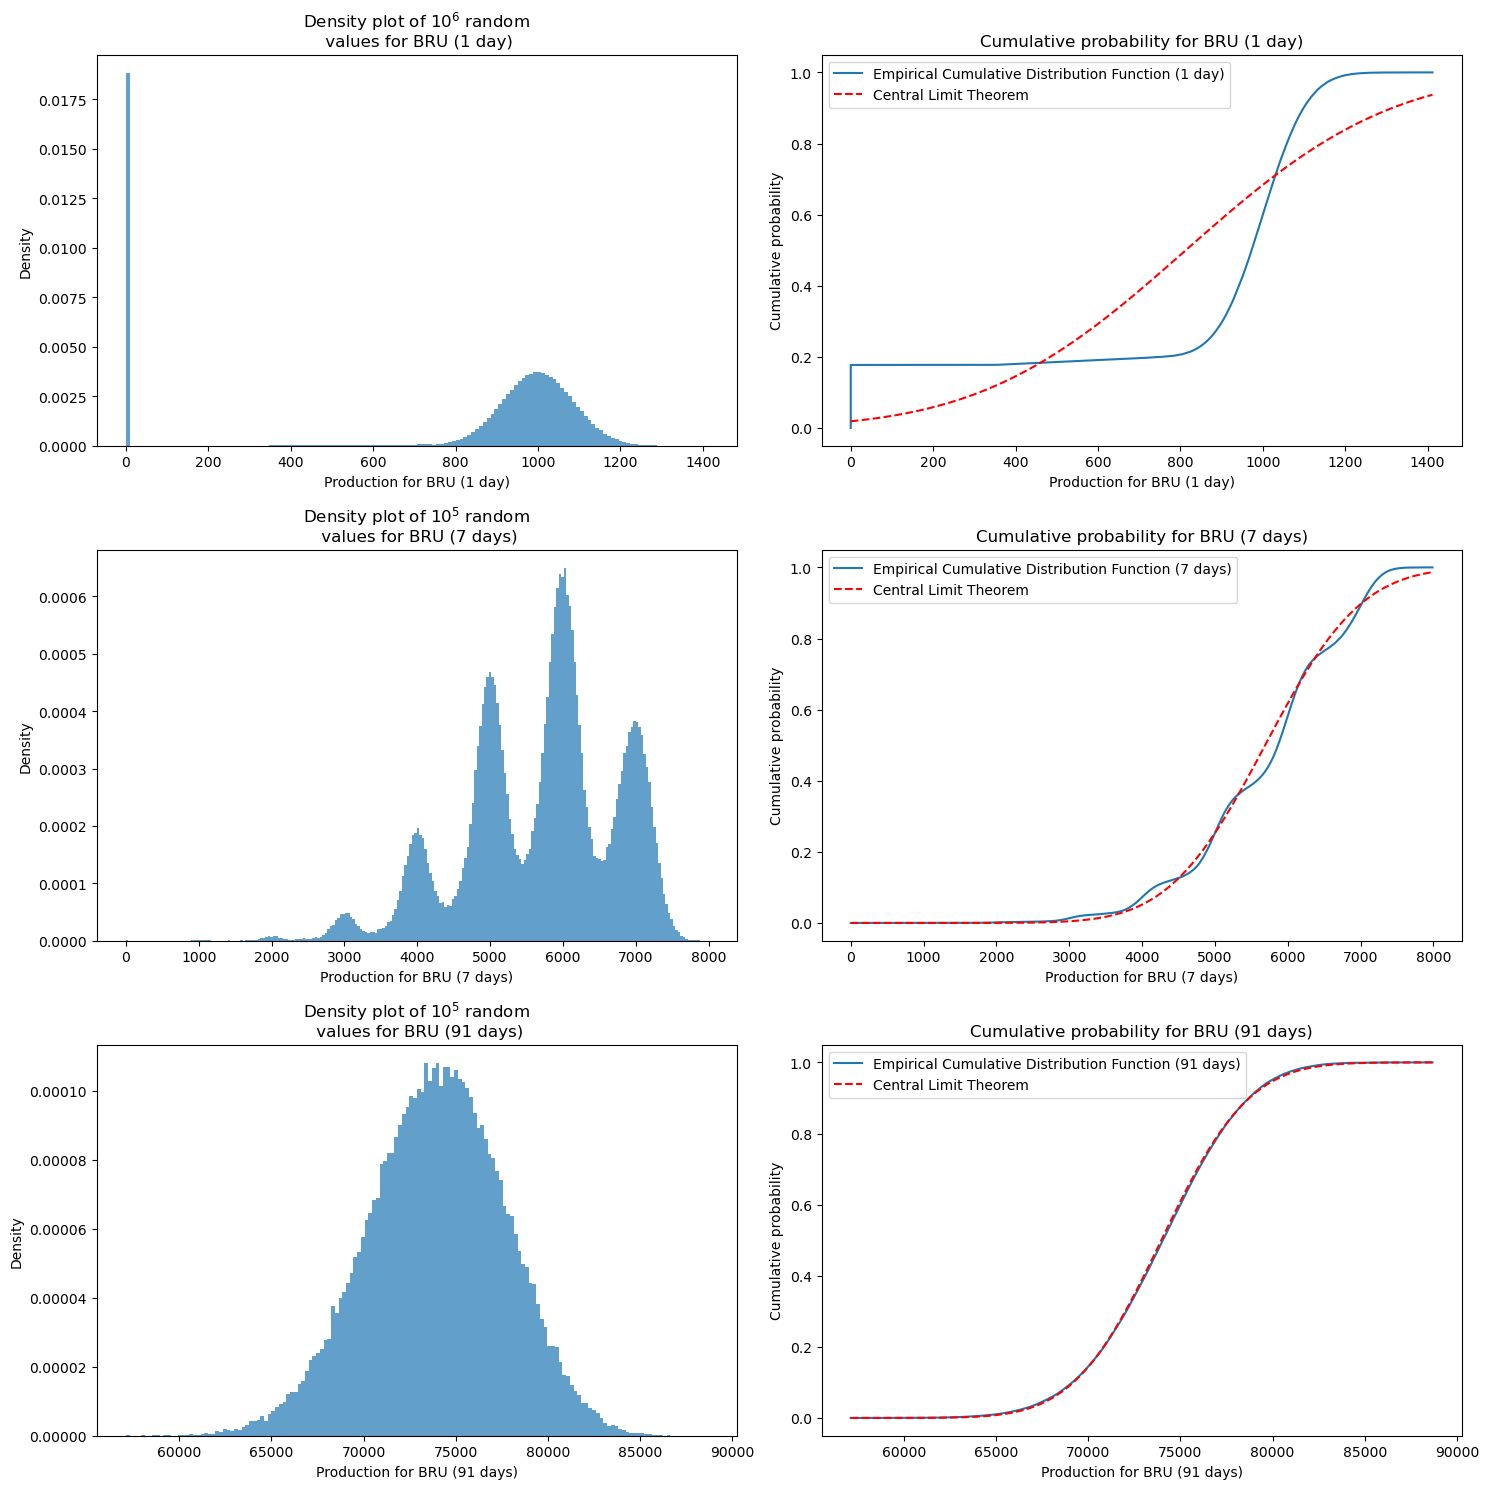

In [13]:
# Ask the user to input the location (with errorhandling)
while True:
    location = input("Enter the location you want to simulate (BRU or STO): " ).upper()
    if location not in ['BRU', 'STO']:
        print("The location entered is not valid. Enter the correct location (BRU or STO)")
        continue
    else:
        break

# We compare 1 day, 1 week and 3 months
n_days_values = [1, 7, 91]


# Collect Data 
filename = os.path.join(output_path, f'{location}.json')

with open(filename, 'r') as json_file:
    data = json.load(json_file)

share_1, share_2, lower_bound_s2, upper_bound_s2, param1_s3, param2_s3 = \
    (data[location][key] for key in ['share_1', 'share_2',
                                     'lower_bound_s2', 'upper_bound_s2',
                                     'param1_s3', 'param2_s3'])


# Simulate data for each n_days value and plot histograms and CDFs
fig, axs = plt.subplots(len(n_days_values), 2, figsize=(15, 5*len(n_days_values)))

for i, n_days in enumerate(n_days_values):
    # Simulate data
    simulated_data = simulate(share_1, share_2, lower_bound_s2, upper_bound_s2, param1_s3, param2_s3, n_days)
    
    # Plot histogram
    plot_multiple_histograms(axs[i, 0], simulated_data, n_days, location)
    
    # Plot CDF
    plot_cdf(axs[i, 1], simulated_data, n_days, location, include_clt=True)

plt.tight_layout()
plt.show()

The Central Limit Theorem states that the sum of a large number of independent, identically distributed random variables will be approximately normally distributed, regardless of the variables' original distribution. The underlying distribution was anything but normally distributed (due to a large proportion of 0), yet the resulting distribution of the sum of these variables, as illustrated in the last right graph, is approximated by a normal distribution.

<font color="red">

# Dit moet nog gebeuren:
- Notebooks checken op overbodige code
- Alle tekst in ENG of NL, ook in functies (kies maar)
- functies opschonen (vb. line_chart_daily_production verwijderen als nergens wordt gebruikt) + docstrings toevoegen (maar ook opschonen!!) in dezelfde taal als hierboven
- Maak een HTML export van de notebooks: File -> Save & Export notebook as... -> HTML -> Voeg deze toe aan de folder 'notebooks' (enkel als iedereen erover eens is dat het klaar is)
- Genereer/overschrijf 'environment.yml' in de projectfolder: Anaconda Navigator -> Environments -> Selecteer de environment -> Klik op “Back-up”. Verwijder evt. overbodige lijnen uit dit bestand.
- Verwijder folders en bestanden in de project-folder die we niet gebruiken
- Update de README vlak voor indienen (check de 'XXXXXXXXXXXXXXXXXXXXX').
- Open SourceTree -> Stage All -> Commit -> Push -> Check op github.com
</font>